# Trabalho prático DAA

### Acidentes Rodoviários

Este dataset contém 5000 casos e 13 features :

- city_name
- magnitude_of_delay
- delay_in_seconds
- affected_roads
- record_date
- luminosity
- avg_temperature
- avg_atm_pressure
- avg_humidity
- avg_wind_speed
- avg_precipitation
- avg_rain
- incidents

Corresponde a um problema de classificação multípla, sendo o atributo target (a prever),
incidents (nível de gravidade de um acidente).
As classficações deste atributo podem ser:

- Very High
- High
- Medium
- Low
- None


Existe também um dataset de teste, com 1206 casos.

## Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import time
import math
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
import joblib

/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/josefam/miniconda3/envs/daa/lib/python3.7/s

## Get the data

In [2]:
data = pd.read_csv('sbstpdaa2223/training_data.csv')
test = pd.read_csv('sbstpdaa2223/test_data.csv')

## Exploração superficial dos datasets

Vista básica do dataset inicial, para treino.

In [3]:
data.shape

(5000, 13)

Vista básica do dataset inicial, para teste.

In [4]:
test.shape

(1206, 12)

In [5]:
data.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [6]:
test.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
0,Guimaraes,UNDEFINED,1211,"N101,N101,N101,N101,N101,N101,",2021-04-13 19:00,LIGHT,15.0,1018.0,80.0,0.0,0.0,Sem Chuva
1,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-13 04:00,DARK,16.0,1018.0,41.0,2.0,0.0,Sem Chuva
2,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-18 19:00,LIGHT,22.0,1017.0,71.0,0.0,0.0,Sem Chuva
3,Guimaraes,UNDEFINED,140,"N101,R206,N101,N101,N101,N101",2021-10-30 15:00,LIGHT,18.0,1008.0,81.0,3.0,0.0,Sem Chuva
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-18 10:00,LIGHT,20.0,1022.0,86.0,0.0,0.0,Sem Chuva


In [7]:
data.nunique()

city_name                1
magnitude_of_delay       3
delay_in_seconds      1186
affected_roads         678
record_date           5000
luminosity               3
avg_temperature         35
avg_atm_pressure        36
avg_humidity            83
avg_wind_speed          11
avg_precipitation        1
avg_rain                 4
incidents                5
dtype: int64

## Missing Values

- É visível que o único atributo que tem valores "perdidos" ou null é o affected_roads(85 linhas - treino, 22- teste).

<AxesSubplot:>

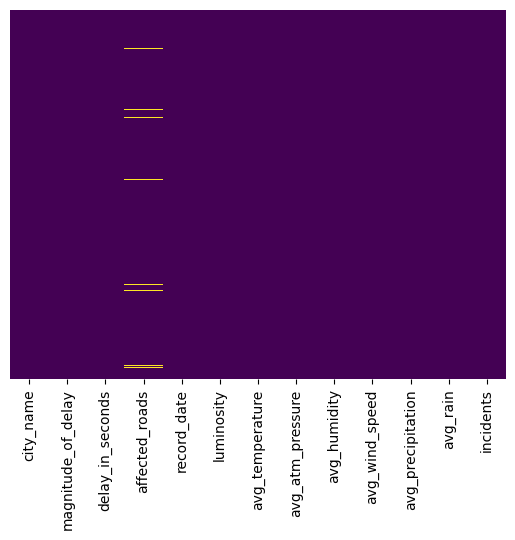

In [8]:
sns.heatmap(data.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [9]:
data.isna().any()

city_name             False
magnitude_of_delay    False
delay_in_seconds      False
affected_roads         True
record_date           False
luminosity            False
avg_temperature       False
avg_atm_pressure      False
avg_humidity          False
avg_wind_speed        False
avg_precipitation     False
avg_rain              False
incidents             False
dtype: bool

In [10]:
#count the null values in each column
data.isna().sum()

city_name              0
magnitude_of_delay     0
delay_in_seconds       0
affected_roads        85
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_precipitation      0
avg_rain               0
incidents              0
dtype: int64

In [11]:
test.isna().sum()

city_name              0
magnitude_of_delay     0
delay_in_seconds       0
affected_roads        22
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_precipitation      0
avg_rain               0
dtype: int64

## Valores duplicados

Os datasets não têm qualquer valor duplicado, pelo que não é necessário tratamento.

In [12]:
print(data.duplicated().sum())
print(data.info())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB
None


In [13]:
print(test.duplicated().sum())
print(test.info())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           1206 non-null   object 
 1   magnitude_of_delay  1206 non-null   object 
 2   delay_in_seconds    1206 non-null   int64  
 3   affected_roads      1184 non-null   object 
 4   record_date         1206 non-null   object 
 5   luminosity          1206 non-null   object 
 6   avg_temperature     1206 non-null   float64
 7   avg_atm_pressure    1206 non-null   float64
 8   avg_humidity        1206 non-null   float64
 9   avg_wind_speed      1206 non-null   float64
 10  avg_precipitation   1206 non-null   float64
 11  avg_rain            1206 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 113.2+ KB
None


## Análise Exploratória

Esta vai ser unicamente realizada com base no dataset de treino, sendo com base neste que o modelo será realizado. (Contudo, preparado para qualquer dataset análogo)

As alterações, com a exceção da remoção de linhas, serão também realizadas no dataset de treino

## Atributos categóricos

### Analisar o target ('incidents')

- Com base nos gráficos a baixo apresentados, é notável que a maioria dos valores encontram-se como none, na classificação do acidente.

- Com a exceção do High, os restantes tem um número de ocorrências semelhantes.

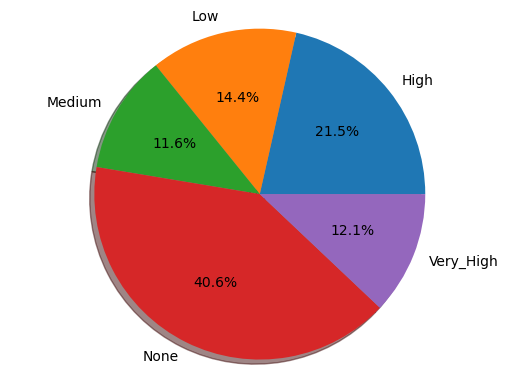

In [14]:
labels = data['incidents'].astype('category').cat.categories.tolist()
counts = data['incidents'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

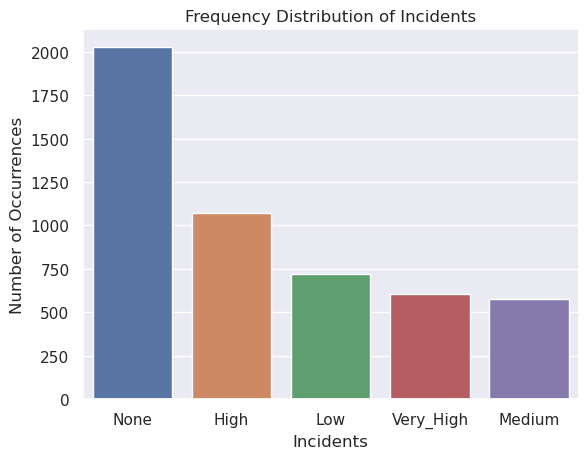

In [15]:
incidents_count = data['incidents'].value_counts()
sns.set(style="darkgrid")

sns.barplot(x=incidents_count.index, y=incidents_count.values)
plt.title('Frequency Distribution of Incidents')

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Incidents', fontsize=12)

plt.show()

### Atributo 'magnitude_of_delay'

- A categoria 'Moderate' tem apenas 8 casos.
- A maioria das linhas estão no caso 'Undefined'(86.3%).

In [16]:
data['magnitude_of_delay'].value_counts()

UNDEFINED    4314
MAJOR         678
MODERATE        8
Name: magnitude_of_delay, dtype: int64

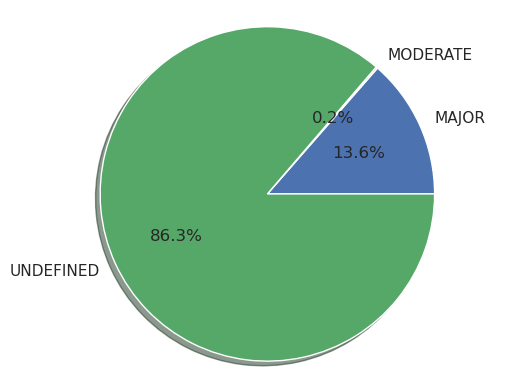

In [17]:
labels = data['magnitude_of_delay'].astype('category').cat.categories.tolist()
counts = data['magnitude_of_delay'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

<AxesSubplot:title={'center':'Magnitude e output target'}>

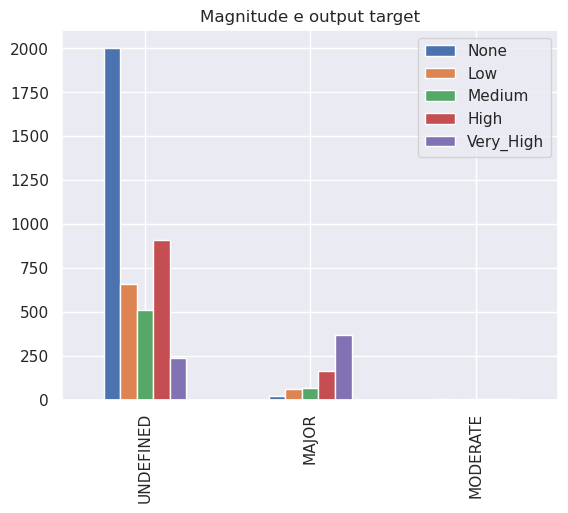

In [18]:
magnitude_target = pd.DataFrame()
magnitude_target['None'] = data[data['incidents'] == 'None']['magnitude_of_delay'].value_counts()
magnitude_target['Low'] = data[data['incidents'] == 'Low']['magnitude_of_delay'].value_counts()
magnitude_target['Medium'] = data[data['incidents'] == 'Medium']['magnitude_of_delay'].value_counts()
magnitude_target['High'] = data[data['incidents'] == 'High']['magnitude_of_delay'].value_counts()
magnitude_target['Very_High'] = data[data['incidents'] == 'Very_High']['magnitude_of_delay'].value_counts()
magnitude_target.plot.bar(title="Magnitude e output target")

### Atributo 'affected_roads'

Neste caso, verifica-se que existe uma quantidade elevado de valores unicos.
Uma vez que existem combinações várias de estradas pelas várias linhas, sendo possível visualizar qu, em alguns casos, só numa linha tem aquela combinação.
Adicionalmente, existe uma repetição excessiva de estradas em cada linha.

In [19]:
data['affected_roads'].value_counts()

N101,N101,N101,N101,N101                                                                                                                                      1514
N101,N101,N101,N101,N101,                                                                                                                                     1078
,                                                                                                                                                              709
N101,N101                                                                                                                                                      149
N101,N101,N101,N101,N101,N101                                                                                                                                  114
                                                                                                                                                              ... 
N101,N101,N105,N105,N1

### Atributo 'record_date'

- Os acidentes, ocorram em datas diferentes (dado a incluir as horas do dia).

In [20]:
data['record_date'].value_counts()

2021-03-15 23:00    1
2021-10-29 07:00    1
2021-04-25 03:00    1
2021-03-17 17:00    1
2021-07-22 00:00    1
                   ..
2021-10-19 00:00    1
2021-10-22 23:00    1
2021-12-04 23:00    1
2021-09-13 23:00    1
2021-12-20 02:00    1
Name: record_date, Length: 5000, dtype: int64

### Atributo 'luminosity'


In [21]:
data['luminosity'].value_counts()

DARK         2489
LIGHT        2325
LOW_LIGHT     186
Name: luminosity, dtype: int64

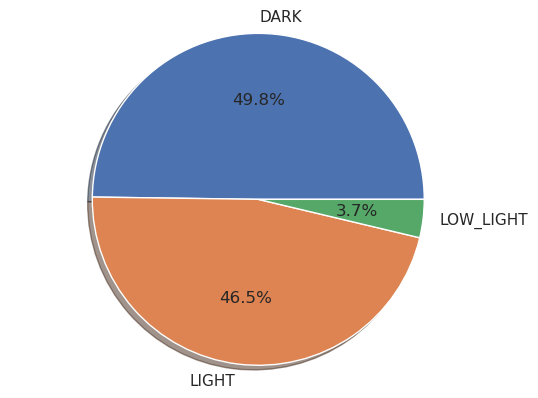

In [22]:
labels = data['luminosity'].astype('category').cat.categories.tolist()
counts = data['luminosity'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

<AxesSubplot:title={'center':'Luminosidade e output target'}>

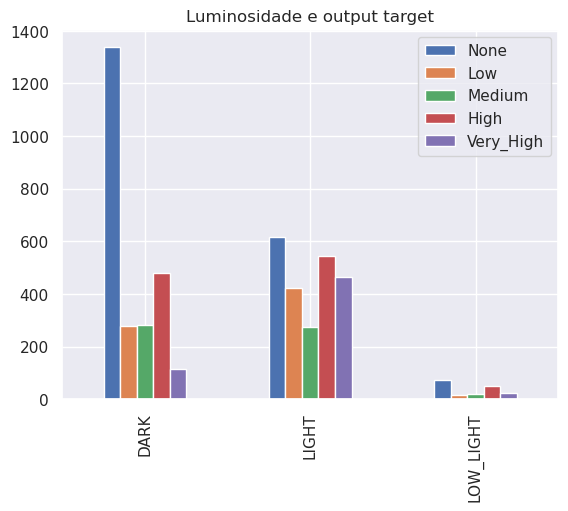

In [23]:
luminosity_target = pd.DataFrame()
luminosity_target['None'] = data[data['incidents'] == 'None']['luminosity'].value_counts()
luminosity_target['Low'] = data[data['incidents'] == 'Low']['luminosity'].value_counts()
luminosity_target['Medium'] = data[data['incidents'] == 'Medium']['luminosity'].value_counts()
luminosity_target['High'] = data[data['incidents'] == 'High']['luminosity'].value_counts()
luminosity_target['Very_High'] = data[data['incidents'] == 'Very_High']['luminosity'].value_counts()
luminosity_target.plot.bar(title="Luminosidade e output target")

### Atributo 'avg_rain'

- É notável que existe uma quantidade mínima de valores na categoria "chuva forte"

In [24]:
data['avg_rain'].value_counts()

Sem Chuva         4756
chuva fraca        214
chuva moderada      27
chuva forte          3
Name: avg_rain, dtype: int64

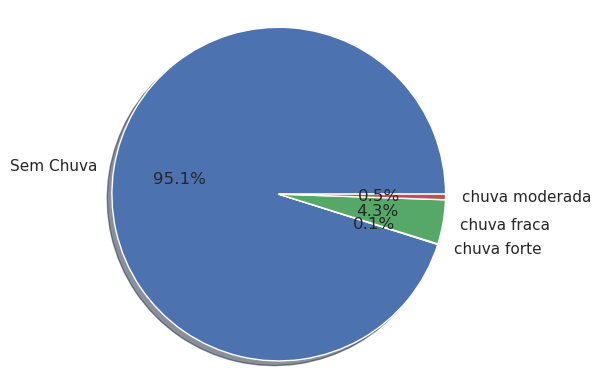

In [25]:
labels = data['avg_rain'].astype('category').cat.categories.tolist()
counts = data['avg_rain'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

<AxesSubplot:title={'center':'Média de chuva e output target'}>

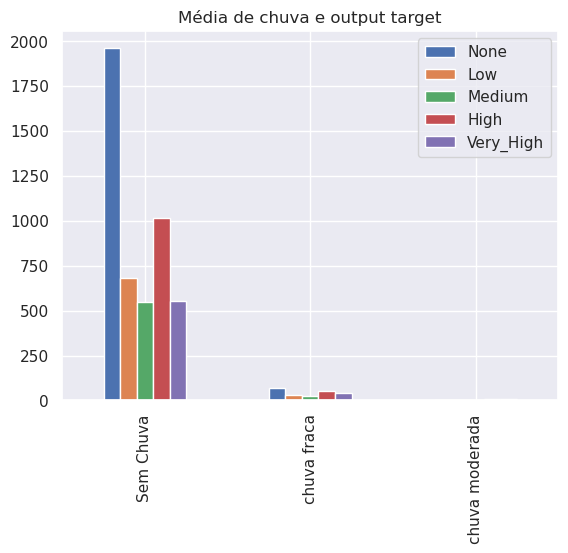

In [26]:
avg_rain_target = pd.DataFrame()
avg_rain_target['None'] = data[data['incidents'] == 'None']['avg_rain'].value_counts()
avg_rain_target['Low'] = data[data['incidents'] == 'Low']['avg_rain'].value_counts()
avg_rain_target['Medium'] = data[data['incidents'] == 'Medium']['avg_rain'].value_counts()
avg_rain_target['High'] = data[data['incidents'] == 'High']['avg_rain'].value_counts()
avg_rain_target['Very_High'] = data[data['incidents'] == 'Very_High']['avg_rain'].value_counts()
avg_rain_target.plot.bar(title="Média de chuva e output target")

### Atributo 'city_name'

- A amostra é numa única cidade (Guimarães).

In [27]:
data['city_name'].value_counts()

Guimaraes    5000
Name: city_name, dtype: int64

## Atributos Numéricos

### Atributo 'delay_in_seconds'

É visível que este atributo está mal distribuído, não só pelo histograma, como pela boxplot.

Com um elevado número de outliers.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


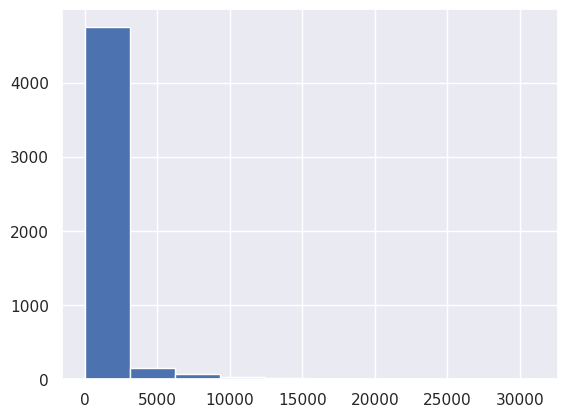

In [28]:
print(f"Histogram: {data['delay_in_seconds'].hist()}")

In [29]:
print(f"Skewness: {data['delay_in_seconds'].skew()}")

Skewness: 6.274560871857796


In [30]:
print(f"Kurtosis: {data['delay_in_seconds'].kurt()}")

Kurtosis: 63.136555037655754


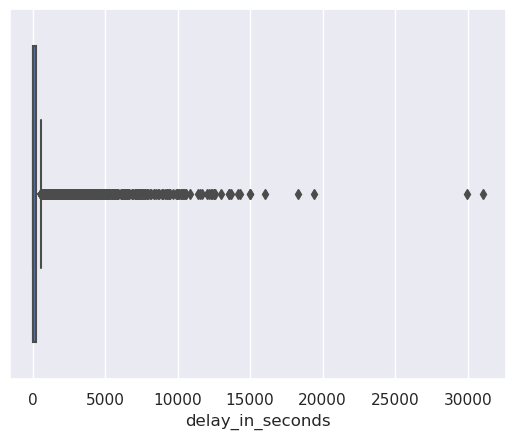

In [31]:
sns.boxplot(x = data['delay_in_seconds'])
plt.show()

### Atributo 'avg_temperature'

Ao contrário do anterior, este apenas tem um número pequeno de outliers (no upper bound), sendo a sua distribuição boa.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


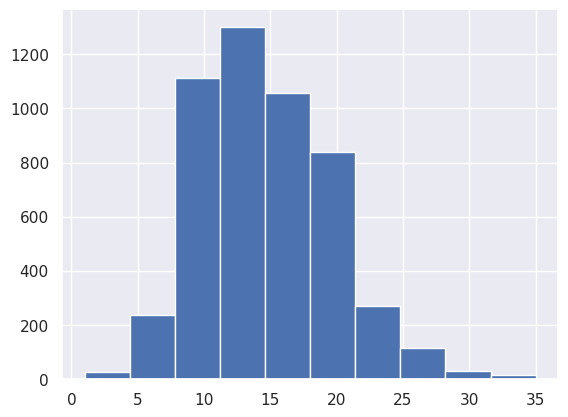

In [32]:
print(f"Histogram: {data['avg_temperature'].hist()}")

<AxesSubplot:xlabel='avg_temperature'>

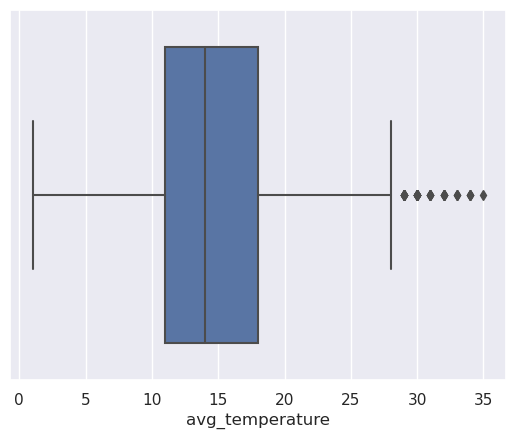

In [33]:
sns.boxplot(x = data['avg_temperature'])

In [34]:
print(f"Skewness: {data['avg_temperature'].skew()}")

Skewness: 0.5605064325594296


In [35]:
print(f"Kurtosis: {data['avg_temperature'].kurt()}")

Kurtosis: 0.5327725282841129


### Atributo 'avg_atm_pressure'

Análogo ao anterior, mas neste caso os outliers encontram-se no lower bound.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


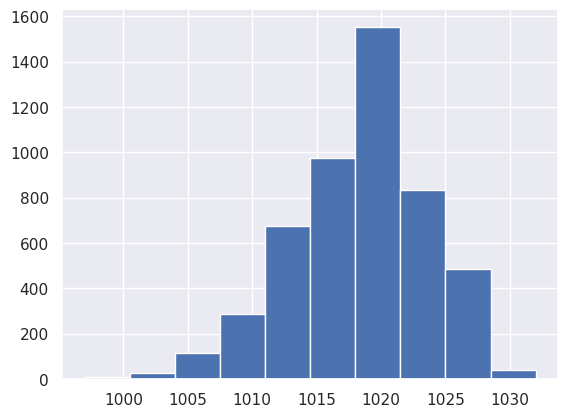

In [36]:
print(f"Histogram: {data['avg_atm_pressure'].hist()}")

<AxesSubplot:xlabel='avg_atm_pressure'>

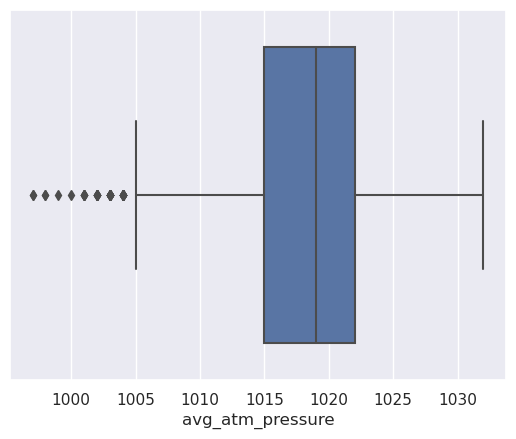

In [37]:
sns.boxplot(x = data['avg_atm_pressure'])

In [38]:
print(f"Skewness: {data['avg_atm_pressure'].skew()}")
print(f"Kurtosis: {data['avg_atm_pressure'].kurt()}")

Skewness: -0.40439693757842093
Kurtosis: 0.12068039465218394


### Atributo 'avg_humidity'

Análogo ao 'avg_atm_pressure'.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


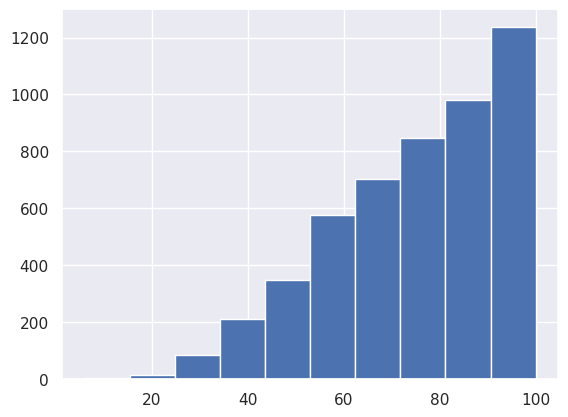

In [39]:
print(f"Histogram: {data['avg_humidity'].hist()}")

<AxesSubplot:xlabel='avg_humidity'>

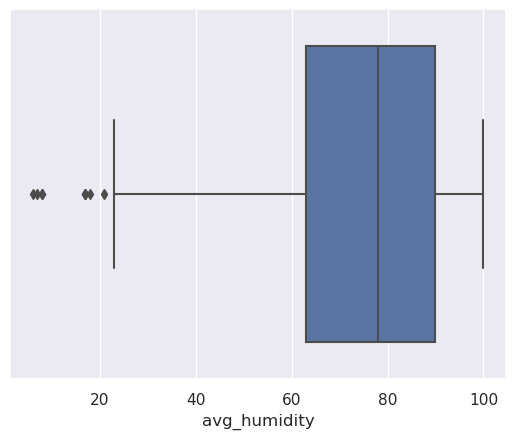

In [40]:
sns.boxplot(x = data['avg_humidity'])

In [41]:
print(f"Skewness: {data['avg_humidity'].skew()}")
print(f"Kurtosis: {data['avg_humidity'].kurt()}")

Skewness: -0.7626793660840018
Kurtosis: -0.2499175078373752


### Atributo 'avg_wind_speed'

Análogo ao 'avg_temerature'.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


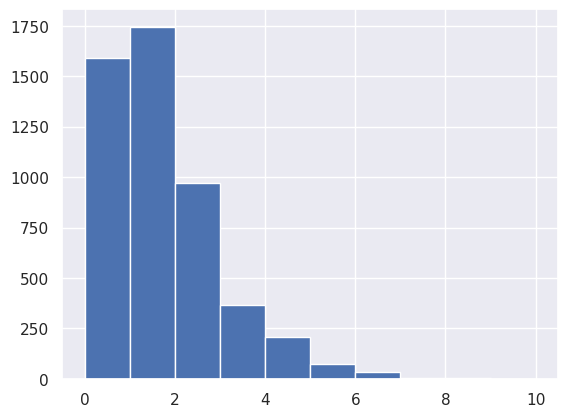

In [42]:
print(f"Histogram: {data['avg_wind_speed'].hist()}")

<AxesSubplot:xlabel='avg_wind_speed'>

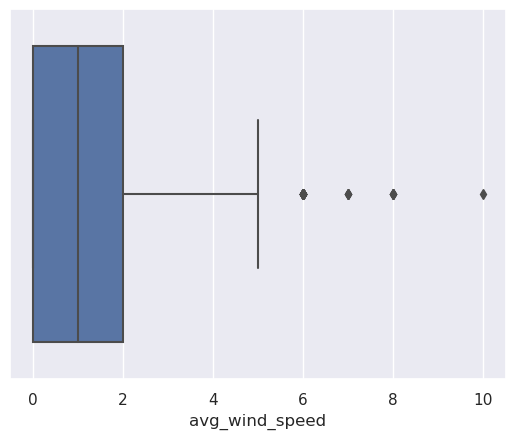

In [43]:
sns.boxplot(x = data['avg_wind_speed'])

In [44]:
print(f"Skewness: {data['avg_wind_speed'].skew()}")
print(f"Kurtosis: {data['avg_wind_speed'].kurt()}")

Skewness: 1.3610238434403679
Kurtosis: 2.5163102006982214


### Atributo 'avg_precipitation'

In [45]:
data['avg_precipitation'].value_counts()

0.0    5000
Name: avg_precipitation, dtype: int64

## Preparação de dados

Nomeadamente nos atributos numéricos que vão ser alterados, serão removidas algumas linhas.
Neste sentido, essas serão unicamente realizadas no dataset de treino.

### Remoção dos atributos 'avg_preciptation' e 'city_name'

- Removidos uma vez que são iguais para tds as linhas.

In [46]:
data.drop(['avg_precipitation', 'city_name'], axis = 1, inplace = True)
test.drop(['avg_precipitation', 'city_name'], axis = 1, inplace = True)

### Realizar Label Encoding no target ('incidents')

In [47]:
replace_map = {'incidents': {'None': 0, 'Low': 1, 'Medium': 2, 'High' : 3, 'Very_High':4}}

In [48]:
data.replace(replace_map, inplace = True)
test.replace(replace_map, inplace = True)
data.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents
0,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,Sem Chuva,0
1,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,Sem Chuva,0
2,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,Sem Chuva,1
3,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,Sem Chuva,4
4,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,Sem Chuva,3


### Realizar Label Encoding do atributo 'avg_rain'

In [49]:
data['avg_rain'].unique()

array(['Sem Chuva', 'chuva moderada', 'chuva fraca', 'chuva forte'],
      dtype=object)

In [50]:
replace_map_rain = {'avg_rain': {'Sem Chuva' : 0, 'chuva fraca' : 1, 'chuva moderada' : 2, 'chuva forte' : 3}}

In [51]:
data.replace(replace_map_rain, inplace = True)
test.replace(replace_map_rain, inplace = True)
data.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents
0,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0,0
1,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0,0
2,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0,1
3,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0,4
4,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0,3


### Realizar Label Encoding com o atributo 'luminosity'

In [52]:
data['luminosity'].unique()

array(['DARK', 'LIGHT', 'LOW_LIGHT'], dtype=object)

In [53]:
replace_map_luminosity = {'luminosity': {'LOW_LIGHT' : 1, 'LIGHT' : 2, 'DARK' : 0}}

In [54]:
data.replace(replace_map_luminosity, inplace = True)
test.replace(replace_map_luminosity, inplace = True)
data.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents
0,UNDEFINED,0,",",2021-03-15 23:00,0,12.0,1013.0,70.0,1.0,0,0
1,UNDEFINED,385,"N101,",2021-12-25 18:00,0,12.0,1007.0,91.0,1.0,0,0
2,UNDEFINED,69,",",2021-03-12 15:00,2,14.0,1025.0,64.0,0.0,0,1
3,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,2,15.0,1028.0,75.0,1.0,0,4
4,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,2,27.0,1020.0,52.0,1.0,0,3


### Substituir os "missing values" no atributo 'affected roads'

Não devemos remover linhas do dataset de teste, pelo que recrreu-se à subsituição.
Substituiu-se pela string "," -> simbólica da não existência de ruas afetadas.

In [55]:
values = {"affected_roads" : ","}
data = data.fillna(value=values)
test = test.fillna(value=values)

In [56]:
data.isna().sum()

magnitude_of_delay    0
delay_in_seconds      0
affected_roads        0
record_date           0
luminosity            0
avg_temperature       0
avg_atm_pressure      0
avg_humidity          0
avg_wind_speed        0
avg_rain              0
incidents             0
dtype: int64

In [57]:
test.isna().sum()

magnitude_of_delay    0
delay_in_seconds      0
affected_roads        0
record_date           0
luminosity            0
avg_temperature       0
avg_atm_pressure      0
avg_humidity          0
avg_wind_speed        0
avg_rain              0
dtype: int64

### Realizar One-Hot-Encoding no 'magnitude_of_delay'

- Contudo, isto resultou na criação de algumas linhas com valores null.

In [58]:
#one hot encoding
label = LabelBinarizer()
lb_results = label.fit_transform(data['magnitude_of_delay'])
lb_results_df = pd.DataFrame(lb_results, columns=label.classes_)
data = pd.concat([data, lb_results_df], axis=1)
data.drop(['magnitude_of_delay'], axis = 1, inplace = True)

lb_results = label.fit_transform(test['magnitude_of_delay'])
lb_results_df = pd.DataFrame(lb_results, columns=label.classes_)
test = pd.concat([test, lb_results_df], axis=1)
test.drop(['magnitude_of_delay'], axis = 1, inplace = True)


In [59]:
data

,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED
0,0,",",2021-03-15 23:00,0,12.0,1013.0,70.0,1.0,0,0,0,0,1
1,385,"N101,",2021-12-25 18:00,0,12.0,1007.0,91.0,1.0,0,0,0,0,1
2,69,",",2021-03-12 15:00,2,14.0,1025.0,64.0,0.0,0,1,0,0,1
3,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,2,15.0,1028.0,75.0,1.0,0,4,1,0,0
4,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,2,27.0,1020.0,52.0,1.0,0,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,"N101,N101,N101,N101,N101,",2021-04-13 00:00,0,13.0,1021.0,56.0,0.0,0,3,0,0,1
4996,0,"N101,N101,N101,N101,N101",2021-07-06 14:00,2,19.0,1017.0,68.0,0.0,0,0,0,0,1
4997,0,",",2021-03-18 03:00,0,13.0,1023.0,47.0,2.0,0,0,0,0,1
4998,0,"N101,N101,N101,N101,N101",2021-11-02 06:00,0,12.0,1014.0,93.0,2.0,0,0,0,0,1


In [60]:
test

,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED
0,1211,"N101,N101,N101,N101,N101,N101,",2021-04-13 19:00,2,15.0,1018.0,80.0,0.0,0,0,0,1
1,0,"N101,N101,N101,N101,N101",2021-10-13 04:00,0,16.0,1018.0,41.0,2.0,0,0,0,1
2,0,"N101,N101,N101,N101,N101",2021-07-18 19:00,2,22.0,1017.0,71.0,0.0,0,0,0,1
3,140,"N101,R206,N101,N101,N101,N101",2021-10-30 15:00,2,18.0,1008.0,81.0,3.0,0,0,0,1
4,0,"N101,N101,N101,N101,N101",2021-10-18 10:00,2,20.0,1022.0,86.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0,N101,2021-12-31 10:00,2,12.0,1025.0,70.0,2.0,0,0,0,1
1202,44,"N101,N101,N101,N101,N101",2021-07-16 00:00,0,24.0,1016.0,39.0,2.0,0,0,0,1
1203,1261,"N101,N101,N101,N101,N101,N101,N101",2021-12-19 15:00,2,13.0,1018.0,60.0,0.0,0,1,0,0
1204,246,",",2021-03-08 17:00,2,15.0,1015.0,50.0,1.0,0,0,0,1


### Atributo 'affected_roads'

- Inicialmente extraiu-se todas as ruas únicas das strings da coluna 'affected_roads'


Existem 4 tipos de estradas nos dois datasets, de teste e treino:
- Estradas nacionais (N)
- Estradas Municipais (EM)
- Itenerários Complementares (IC)
- Ruas (R)

Criou-se 5 novas colunas, com base nesta análise:
- Uma para cada tipo de estrada (N | EM | IC | R)
- o número de estradas únicas afetadas (n.estradas)

E realizou-se para as ruas uma estratégia de "one-hot-encoding",
colocando uma opção binária para caso as ruas afetadas são ou não
daquele tipo.

No final, apresentam-se 17 colunas no dataset.

In [61]:
all_roads = []

for row in data.index:
    roads = data['affected_roads'][row]

    roads_split = roads.split(',')
    for r in range(len(roads_split)):
        if(len(roads_split[r]) > 0):
            road = roads_split[r]
            all_roads.append(road)


all_roads = set(all_roads)

print("Todas as estradas unicas: ",all_roads)


Todas as estradas unicas:  {'N309', 'N101', 'EM579', 'R206', 'N206', 'N310', 'IC5 - N206', 'N207-4', 'IC5', 'N105'}


In [62]:
test_all_roads = []

for row in test.index:
    roads = test['affected_roads'][row]
    roads_split = roads.split(',')
    for r in range(len(roads_split)):
        if(len(roads_split[r]) > 0):
            road = roads_split[r]
            test_all_roads.append(road)


test_all_roads = set(test_all_roads)

print("Todas as estradas unicas: ",test_all_roads)

Todas as estradas unicas:  {'N309', 'N101', 'EM579', 'R206', 'N101 - N310', 'N206', 'N310', 'N207-4', 'IC5', 'N105'}


In [63]:
affected_ohe = []

for row in data.index:
    roads = data['affected_roads'][row]
    roads_split = roads.split(',')
    
    has_n = 0
    has_em = 0
    has_ic = 0
    has_r = 0
    n_roads = 0

    if 'N' in roads:
        has_n = 1

    if 'EM' in roads:
        has_em = 1 
    
    if 'IC' in roads:
        has_ic = 1

    if 'R' in roads:
        has_r = 1

    roads_list = []
    for road in roads_split:
        if road != "":
            roads_list.append(road)

    roads_set = set(roads_list)

    affected_ohe.append({
        'N': has_n, 
        'EM':has_em, 
        'IC':has_ic, 
        'R': has_r, 
       'n.estradas': len(roads_set)
    })

    affected_df = pd.DataFrame(affected_ohe)

affected_df

,N,EM,IC,R,n.estradas
0,0,0,0,0,0
1,1,0,0,0,1
2,0,0,0,0,0
3,1,0,0,1,3
4,1,0,0,0,1
...,...,...,...,...,...
4995,1,0,0,0,1
4996,1,0,0,0,1
4997,0,0,0,0,0
4998,1,0,0,0,1


In [64]:
data = pd.merge(data ,affected_df,left_index=True, right_index=True)
data.drop(['affected_roads'], axis = 1, inplace = True)
data

,delay_in_seconds,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas
0,0,2021-03-15 23:00,0,12.0,1013.0,70.0,1.0,0,0,0,0,1,0,0,0,0,0
1,385,2021-12-25 18:00,0,12.0,1007.0,91.0,1.0,0,0,0,0,1,1,0,0,0,1
2,69,2021-03-12 15:00,2,14.0,1025.0,64.0,0.0,0,1,0,0,1,0,0,0,0,0
3,2297,2021-09-29 09:00,2,15.0,1028.0,75.0,1.0,0,4,1,0,0,1,0,0,1,3
4,0,2021-06-13 11:00,2,27.0,1020.0,52.0,1.0,0,3,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,2021-04-13 00:00,0,13.0,1021.0,56.0,0.0,0,3,0,0,1,1,0,0,0,1
4996,0,2021-07-06 14:00,2,19.0,1017.0,68.0,0.0,0,0,0,0,1,1,0,0,0,1
4997,0,2021-03-18 03:00,0,13.0,1023.0,47.0,2.0,0,0,0,0,1,0,0,0,0,0
4998,0,2021-11-02 06:00,0,12.0,1014.0,93.0,2.0,0,0,0,0,1,1,0,0,0,1


In [65]:
affected_ohe = []

for row in test.index:
    roads = test['affected_roads'][row]
    roads_split = roads.split(',')
    
    has_n = 0
    has_em = 0
    has_ic = 0
    has_r = 0
    n_roads = 0

    if 'N' in roads:
        has_n = 1

    if 'EM' in roads:
        has_em = 1 
    
    if 'IC' in roads:
        has_ic = 1

    if 'R' in roads:
        has_r = 1

    roads_list = []
    for road in roads_split:
        if road != "":
            roads_list.append(road)

    roads_set = set(roads_list)

    affected_ohe.append({
        'N': has_n, 
        'EM':has_em, 
        'IC':has_ic, 
        'R': has_r, 
        'n.estradas': len(roads_set)
    })

    affected_df = pd.DataFrame(affected_ohe)

affected_df

,N,EM,IC,R,n.estradas
0,1,0,0,0,1
1,1,0,0,0,1
2,1,0,0,0,1
3,1,0,0,1,2
4,1,0,0,0,1
...,...,...,...,...,...
1201,1,0,0,0,1
1202,1,0,0,0,1
1203,1,0,0,0,1
1204,0,0,0,0,0


In [66]:
test = pd.merge(test ,affected_df,left_index=True, right_index=True)
test.drop(['affected_roads'], axis = 1, inplace = True)
test

,delay_in_seconds,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas
0,1211,2021-04-13 19:00,2,15.0,1018.0,80.0,0.0,0,0,0,1,1,0,0,0,1
1,0,2021-10-13 04:00,0,16.0,1018.0,41.0,2.0,0,0,0,1,1,0,0,0,1
2,0,2021-07-18 19:00,2,22.0,1017.0,71.0,0.0,0,0,0,1,1,0,0,0,1
3,140,2021-10-30 15:00,2,18.0,1008.0,81.0,3.0,0,0,0,1,1,0,0,1,2
4,0,2021-10-18 10:00,2,20.0,1022.0,86.0,0.0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0,2021-12-31 10:00,2,12.0,1025.0,70.0,2.0,0,0,0,1,1,0,0,0,1
1202,44,2021-07-16 00:00,0,24.0,1016.0,39.0,2.0,0,0,0,1,1,0,0,0,1
1203,1261,2021-12-19 15:00,2,13.0,1018.0,60.0,0.0,0,1,0,0,1,0,0,0,1
1204,246,2021-03-08 17:00,2,15.0,1015.0,50.0,1.0,0,0,0,1,0,0,0,0,0


### Atributo 'record_date'

In [67]:
data_dt = data.copy()

In [68]:
data_dt['record_date'] = pd.to_datetime(data_dt['record_date'], format='%Y-%m-%d %H:%M', errors='coerce')

In [69]:
data_dt['record_date'].head()

0   2021-03-15 23:00:00
1   2021-12-25 18:00:00
2   2021-03-12 15:00:00
3   2021-09-29 09:00:00
4   2021-06-13 11:00:00
Name: record_date, dtype: datetime64[ns]

In [70]:
data['date_year'] = data_dt['record_date'].dt.year
data['date_month'] = data_dt['record_date'].dt.month
data['date_day'] = data_dt['record_date'].dt.day
data['date_hour'] = data_dt['record_date'].dt.hour
data.drop(['record_date'], axis=1, inplace = True)
test['date_year'] = data_dt['record_date'].dt.year
test['date_month'] = data_dt['record_date'].dt.month
test['date_day'] = data_dt['record_date'].dt.day
test['date_hour'] = data_dt['record_date'].dt.hour
test.drop(['record_date'], axis=1, inplace = True)
data.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_year,date_month,date_day,date_hour
0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,1,0,0,0,0,0,2021,3,15,23
1,385,0,12.0,1007.0,91.0,1.0,0,0,0,0,1,1,0,0,0,1,2021,12,25,18
2,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,1,0,0,0,0,0,2021,3,12,15
3,2297,2,15.0,1028.0,75.0,1.0,0,4,1,0,0,1,0,0,1,3,2021,9,29,9
4,0,2,27.0,1020.0,52.0,1.0,0,3,0,0,1,1,0,0,0,1,2021,6,13,11


In [71]:
data['date_year'].unique()

array([2021])

In [72]:
data.drop(['date_year'], axis=1, inplace = True)
test.drop(['date_year'], axis=1, inplace = True)

In [73]:
data.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,1,0,0,0,0,0,3,15,23
1,385,0,12.0,1007.0,91.0,1.0,0,0,0,0,1,1,0,0,0,1,12,25,18
2,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,1,0,0,0,0,0,3,12,15
3,2297,2,15.0,1028.0,75.0,1.0,0,4,1,0,0,1,0,0,1,3,9,29,9
4,0,2,27.0,1020.0,52.0,1.0,0,3,0,0,1,1,0,0,0,1,6,13,11


In [74]:
test.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,1211,2,15.0,1018.0,80.0,0.0,0,0,0,1,1,0,0,0,1,3,15,23
1,0,0,16.0,1018.0,41.0,2.0,0,0,0,1,1,0,0,0,1,12,25,18
2,0,2,22.0,1017.0,71.0,0.0,0,0,0,1,1,0,0,0,1,3,12,15
3,140,2,18.0,1008.0,81.0,3.0,0,0,0,1,1,0,0,1,2,9,29,9
4,0,2,20.0,1022.0,86.0,0.0,0,0,0,1,1,0,0,0,1,6,13,11


## Atributos numéricos a manipular

Este capítulo foi criado baseados ns boxplots e histogramas visualizados na exploração dos dados, dos atributos numéricos.

Para este cas o grupo definiu que, se o número de outliers for inferior e/ou igual a 5%, procedia-se à sua remoção.
Caso contrário, realiza-se a tranformação dos dados.

### Atributo 'delay_in_seconds'

Os outliers no upper bound coorespondem a 17% dos dados.
Por este motivo, escolheu-se a transformação com log (Log Transformation) uma vez que o atributo tem valores muito enviesados.
Neste caso, os valores vão ser aproximados ao normal; dentro das possibilidades.

In [173]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['delay_in_seconds'].quantile(q=0.25)
Q3 = data['delay_in_seconds'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim_delay = Q1 - 1.5 * IQR
upperLim_delay = Q3 + 1.5 * IQR

print(lowerLim_delay)
print(upperLim_delay)

234.0
-351.0
585.0


In [174]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['delay_in_seconds'] < lowerLim_delay]['delay_in_seconds'].count())
print("Depois do upper bound: ",data[data['delay_in_seconds'] > upperLim_delay]['delay_in_seconds'].count())

Antes do lower bound:  0
Depois do upper bound:  884


In [175]:
data['delay_in_seconds'].mask(data['delay_in_seconds'] > upperLim_delay, upperLim_delay, inplace=True)

<AxesSubplot:xlabel='delay_in_seconds'>

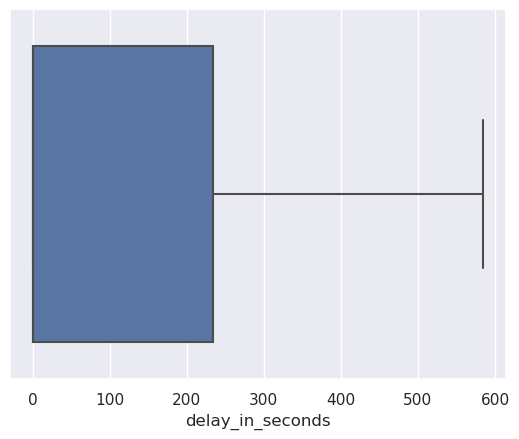

In [176]:
sns.boxplot(x = data['delay_in_seconds'])

### Atributo 'avg_temperature'

Os outliers são no upper bound, e correspondem a 0.85% dos dados.
Pelo que estes serão removidos.

In [177]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_temperature'].quantile(q=0.25)
Q3 = data['avg_temperature'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim_temp = Q1 - 1.5 * IQR
upperLim_temp = Q3 + 1.5 * IQR

print(lowerLim_temp)
print(upperLim_temp)

7.0
0.5
28.5


In [178]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_temperature'] < lowerLim_temp]['avg_temperature'].count())
print("Depois do upper bound: ",data[data['avg_temperature'] > upperLim_temp]['avg_temperature'].count())

Antes do lower bound:  0
Depois do upper bound:  43


In [179]:
data.drop(data[(data['avg_temperature'] > upperLim_temp)].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_temperature'>

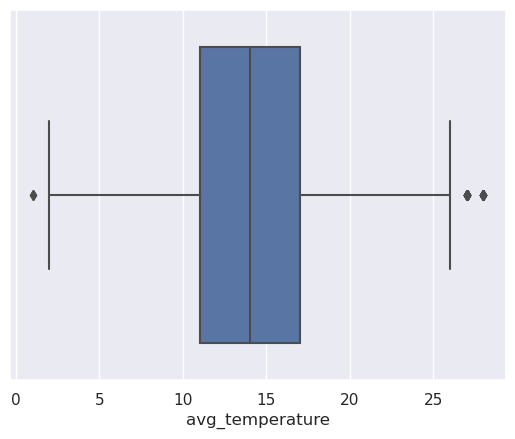

In [180]:
sns.boxplot(x = data['avg_temperature'])

### Atributo 'avg_atm_pressure'

Os outliers encontram-se no upperbound e correspondem a aproximadamente 0.87% dos dados.
Serão removidos.

In [181]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_atm_pressure'].quantile(q=0.25)
Q3 = data['avg_atm_pressure'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim = Q1 - 1.5 * IQR
upperLim = Q3 + 1.5 * IQR

print(lowerLim)
print(upperLim)

7.0
1004.5
1032.5


In [182]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_atm_pressure'] < lowerLim]['avg_atm_pressure'].count())
print("Depois do upper bound: ",data[data['avg_atm_pressure'] > upperLim]['avg_atm_pressure'].count())

Antes do lower bound:  45
Depois do upper bound:  0


In [183]:
data.drop(data[(data['avg_atm_pressure'] < lowerLim)].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_atm_pressure'>

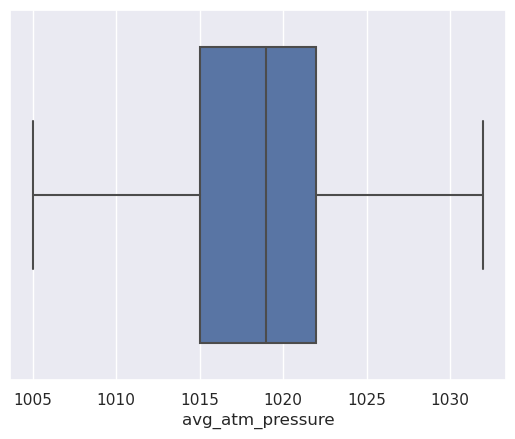

In [184]:
sns.boxplot(x = data['avg_atm_pressure'])

### Atributo 'avg_humidity'

In [185]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_humidity'].quantile(q=0.25)
Q3 = data['avg_humidity'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim = Q1 - 1.5 * IQR
upperLim = Q3 + 1.5 * IQR

print(lowerLim)
print(upperLim)

27.0
22.5
130.5


In [186]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_humidity'] < lowerLim]['avg_humidity'].count())
print("Depois do upper bound: ",data[data['avg_humidity'] > upperLim]['avg_humidity'].count())

Antes do lower bound:  7
Depois do upper bound:  0


In [187]:
data.drop(data[(data['avg_humidity'] < lowerLim)].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_humidity'>

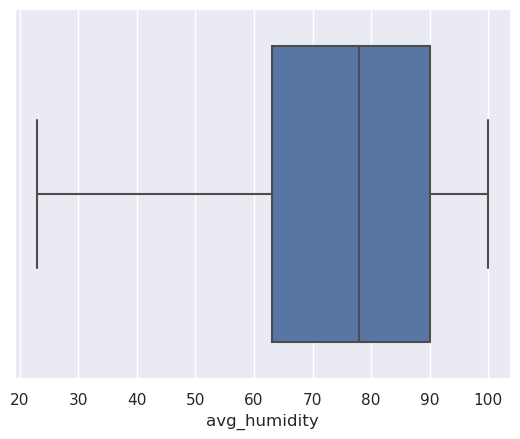

In [188]:
sns.boxplot(x = data['avg_humidity'])

### Atributo 'avg_wind_speed'

In [189]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_wind_speed'].quantile(q=0.25)
Q3 = data['avg_wind_speed'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim = Q1 - 1.5 * IQR
upperLim = Q3 + 1.5 * IQR

print(lowerLim)
print(upperLim)

2.0
-3.0
5.0


In [190]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_wind_speed'] < lowerLim]['avg_wind_speed'].count())
print("Depois do upper bound: ",data[data['avg_wind_speed'] > upperLim]['avg_wind_speed'].count())

Antes do lower bound:  0
Depois do upper bound:  42


In [191]:
data.drop(data[(data['avg_wind_speed'] > upperLim )].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_wind_speed'>

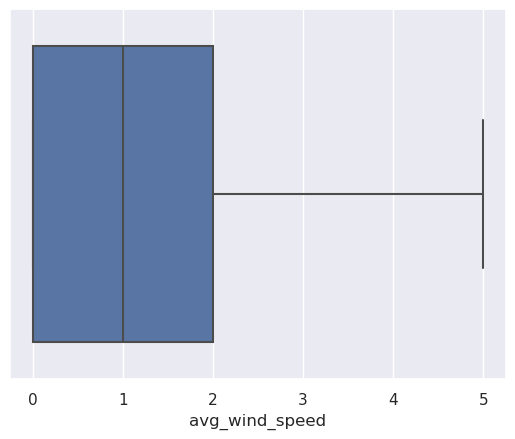

In [192]:
sns.boxplot(x = data['avg_wind_speed'])

### Matriz de Correlação

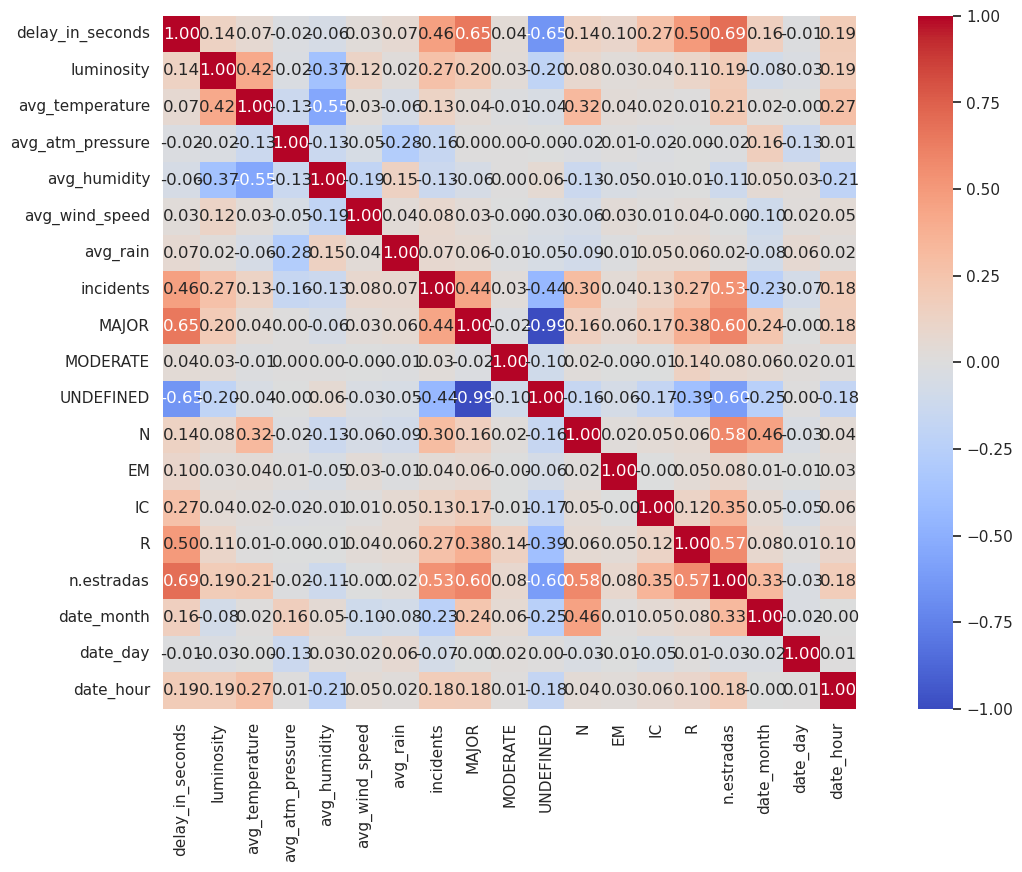

In [75]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True, fmt='.2f', cmap='coolwarm');

In [194]:
# sns.pairplot(data, hue='incidents', palette='Set1')

# Train Test Split

Realizar o split dos dados para treino e teste.
Neste exemlo, foram utilizados 20% dos dados para teste...os restantes 60% para treino.
Também foi utilizada a opção stratify (com Y) para tentar ter uma amostra com todos os tipos de 
classificação possiveis (5).

In [76]:
data

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,1,0,0,0,0,0,3,15,23
1,385,0,12.0,1007.0,91.0,1.0,0,0,0,0,1,1,0,0,0,1,12,25,18
2,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,1,0,0,0,0,0,3,12,15
3,2297,2,15.0,1028.0,75.0,1.0,0,4,1,0,0,1,0,0,1,3,9,29,9
4,0,2,27.0,1020.0,52.0,1.0,0,3,0,0,1,1,0,0,0,1,6,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,13.0,1021.0,56.0,0.0,0,3,0,0,1,1,0,0,0,1,4,13,0
4996,0,2,19.0,1017.0,68.0,0.0,0,0,0,0,1,1,0,0,0,1,7,6,14
4997,0,0,13.0,1023.0,47.0,2.0,0,0,0,0,1,0,0,0,0,0,3,18,3
4998,0,0,12.0,1014.0,93.0,2.0,0,0,0,0,1,1,0,0,0,1,11,2,6


In [77]:
test

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,1211,2,15.0,1018.0,80.0,0.0,0,0,0,1,1,0,0,0,1,3,15,23
1,0,0,16.0,1018.0,41.0,2.0,0,0,0,1,1,0,0,0,1,12,25,18
2,0,2,22.0,1017.0,71.0,0.0,0,0,0,1,1,0,0,0,1,3,12,15
3,140,2,18.0,1008.0,81.0,3.0,0,0,0,1,1,0,0,1,2,9,29,9
4,0,2,20.0,1022.0,86.0,0.0,0,0,0,1,1,0,0,0,1,6,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0,2,12.0,1025.0,70.0,2.0,0,0,0,1,1,0,0,0,1,7,27,11
1202,44,0,24.0,1016.0,39.0,2.0,0,0,0,1,1,0,0,0,1,4,13,13
1203,1261,2,13.0,1018.0,60.0,0.0,0,1,0,0,1,0,0,0,1,3,5,1
1204,246,2,15.0,1015.0,50.0,1.0,0,0,0,1,0,0,0,0,0,7,4,12


In [78]:
X = data.drop('incidents', axis=1)
Y = data['incidents'].to_frame()

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=2022, stratify=Y)

## Decision Tree

Implementação do modelo com base em árvores de decisão.

Obteve-se uma accuracy de, aproximadamente, 88%.

In [80]:
#Create an instance of a Decision Tree classifier
#Again, defining the random_state for reproducibility
clf = DecisionTreeClassifier(random_state=2022)

In [81]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2022)

In [82]:
predictions = clf.predict(X_test)
predictions

array([2, 3, 4, 0, 0, 3, 0, 3, 0, 0, 1, 0, 0, 4, 4, 0, 2, 3, 1, 3, 0, 0,
       2, 1, 1, 3, 3, 0, 2, 1, 2, 1, 4, 4, 0, 0, 0, 0, 1, 0, 4, 4, 3, 0,
       0, 0, 3, 1, 0, 3, 0, 4, 2, 0, 3, 4, 3, 0, 0, 4, 0, 0, 1, 0, 0, 1,
       0, 2, 4, 0, 4, 0, 0, 4, 0, 3, 3, 4, 0, 2, 0, 0, 3, 0, 1, 1, 0, 2,
       0, 1, 2, 4, 2, 4, 2, 2, 0, 4, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 4,
       3, 0, 2, 0, 0, 3, 3, 0, 1, 1, 2, 4, 0, 0, 0, 3, 0, 3, 1, 2, 3, 2,
       0, 3, 4, 1, 1, 0, 1, 3, 3, 0, 3, 2, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       3, 0, 1, 4, 1, 0, 1, 3, 2, 0, 0, 4, 0, 3, 0, 3, 3, 3, 4, 3, 2, 4,
       4, 0, 1, 0, 0, 0, 0, 4, 0, 4, 2, 4, 2, 4, 3, 1, 1, 0, 0, 0, 2, 3,
       0, 3, 3, 2, 0, 0, 0, 0, 1, 4, 4, 3, 3, 4, 0, 4, 3, 2, 0, 1, 4, 3,
       3, 0, 0, 4, 1, 2, 4, 2, 3, 0, 2, 0, 0, 3, 4, 1, 3, 4, 1, 0, 2, 3,
       0, 0, 2, 3, 4, 0, 0, 3, 2, 0, 0, 0, 3, 4, 1, 0, 1, 1, 0, 1, 0, 3,
       3, 1, 0, 3, 0, 2, 2, 2, 4, 1, 3, 2, 3, 0, 2, 3, 0, 1, 0, 0, 0, 3,
       0, 4, 0, 0, 0, 2, 4, 4, 1, 4, 0, 0, 0, 2, 0,

In [83]:
confusion_matrix(y_test, predictions)

array([[389,  12,   1,   3,   0],
       [ 14, 113,  10,   7,   0],
       [  1,   6, 100,   9,   0],
       [  0,   3,   9, 186,  16],
       [  0,   0,   3,  15, 103]])

In [84]:
accuracy_score(y_test, predictions)

0.891

In [85]:
precision_score(y_test, predictions, average='macro')

0.8660327526483013

In [86]:
recall_score(y_test, predictions, average='macro')

0.8655367125652236

In [87]:
f1_score(y_test, predictions, average='macro')

0.8653854004417276

In [88]:
fbeta_score(y_test, predictions, beta=0.5, average='macro')

0.8656767203737727

### Operações para criar o ficheiro de submissão (em csv)

- 1) Os dados de treino são agora todo o dataset de treino, sendo isto análogo para os dados de teste (dataset inteiro de teste)
- 2) É realizado novamente o fit do modelo
- 3) São calculadas as previsões (predict)
- 4) Criado o ficheiro csv

In [ ]:
#to csv
X_train = data.drop(['incidents'], axis=1)
y_train = data['incidents'].to_frame()
X_test = test

In [ ]:
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
#to csv
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

predictions

## SVM

Treino a partir de support vector machines. 

- É realizado o treino do Support Vector Classifier com 10-Fold Cross validation
- Adicionalmente também é realizado com GridSearch.

È visível pellos gráficos (matrizes de confusão) que a distribuição de valores acertados nas suas respetivas labels é muito melhor no caso do GridSearch.

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 3193 to 2008
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delay_in_seconds  4000 non-null   int64  
 1   luminosity        4000 non-null   int64  
 2   avg_temperature   4000 non-null   float64
 3   avg_atm_pressure  4000 non-null   float64
 4   avg_humidity      4000 non-null   float64
 5   avg_wind_speed    4000 non-null   float64
 6   avg_rain          4000 non-null   int64  
 7   MAJOR             4000 non-null   int64  
 8   MODERATE          4000 non-null   int64  
 9   UNDEFINED         4000 non-null   int64  
 10  N                 4000 non-null   int64  
 11  EM                4000 non-null   int64  
 12  IC                4000 non-null   int64  
 13  R                 4000 non-null   int64  
 14  n.estradas        4000 non-null   int64  
 15  date_month        4000 non-null   int64  
 16  date_day          4000 non-null   int64

### Treino com Cross Validation

In [90]:
cross_valid_model = SVC(random_state=2022)
scores = cross_val_score(cross_valid_model, X_train, np.ravel(y_train), cv=10)
scores

array([0.535 , 0.55  , 0.5225, 0.5725, 0.5575, 0.5425, 0.5375, 0.5275,
       0.53  , 0.555 ])

In [91]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.54 accuracy with a standard deviation of 0.01


In [92]:
model = SVC(random_state=2021)
model.fit(X_train, np.ravel(y_train))

SVC(random_state=2021)

In [93]:
print("%0.2f accuracy" % accuracy_score(y_test, predictions))

0.89 accuracy


/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


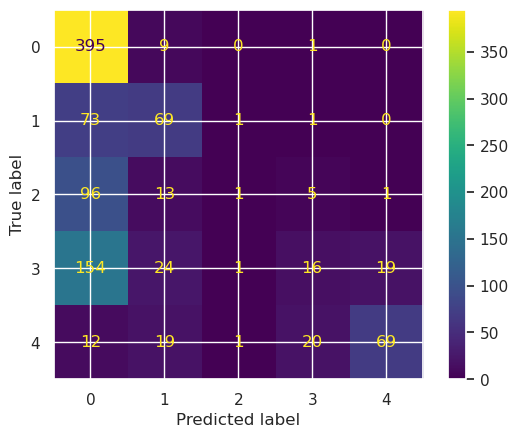

In [94]:
plot_confusion_matrix(model, X_test, y_test)

In [95]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       405
           1       0.84      0.78      0.81       144
           2       0.81      0.86      0.84       116
           3       0.85      0.87      0.86       214
           4       0.87      0.85      0.86       121

    accuracy                           0.89      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.89      0.89      0.89      1000



### Treino com GridSearch

In [96]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

In [97]:
grid = GridSearchCV(SVC(random_state=2022), param_grid, refit=True, verbose=3, n_jobs=-1)

In [98]:
grid.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.431 total time=   1.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   3.1s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.405 total time=   3.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.406 total time=   2.8s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.405 total time=   3.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.405 total time=   3.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   3.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   3.3s
[CV 3/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.431 total time=   1.7s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.555 total time=   1.6s
[CV 4/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.436 total time=   1.7s
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf

GridSearchCV(estimator=SVC(random_state=2022), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

### Inspecionar os melhores parâmetros encontrados pelo GridSearch

In [99]:
grid.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [100]:
grid.best_estimator_

SVC(C=1000, gamma=0.001, random_state=2022)

/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


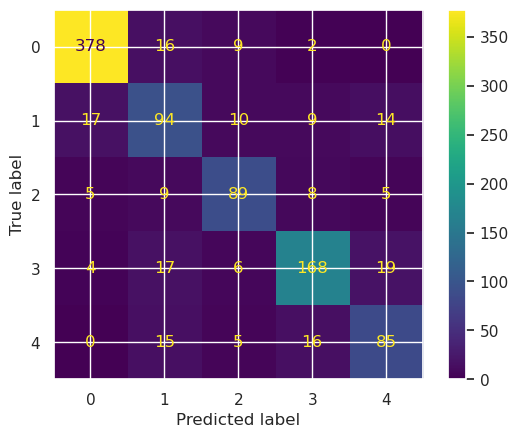

In [101]:
plot_confusion_matrix(grid, X_test, y_test)

In [102]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       405
           1       0.62      0.65      0.64       144
           2       0.75      0.77      0.76       116
           3       0.83      0.79      0.81       214
           4       0.69      0.70      0.70       121

    accuracy                           0.81      1000
   macro avg       0.76      0.77      0.77      1000
weighted avg       0.82      0.81      0.81      1000



### Transformação em ficheiro CSV (para submissão)

In [435]:
#to csv
X_train = data.drop(['incidents'], axis=1)
y_train = data['incidents'].to_frame()
X_test = test

In [436]:
#to csv
predictions = grid.predict(test)
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

## Neural Networks

Construção de uma rede neural para resolução das previsões para o problema.


In [103]:
#Scale the data
scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(X)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(Y)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)
Y_scaled = pd.DataFrame(scaler_y.transform(Y[Y.columns]), columns=Y.columns)

In [104]:
X.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,0,0,12.0,1013.0,70.0,1.0,0,0,0,1,0,0,0,0,0,3,15,23
1,385,0,12.0,1007.0,91.0,1.0,0,0,0,1,1,0,0,0,1,12,25,18
2,69,2,14.0,1025.0,64.0,0.0,0,0,0,1,0,0,0,0,0,3,12,15
3,2297,2,15.0,1028.0,75.0,1.0,0,1,0,0,1,0,0,1,3,9,29,9
4,0,2,27.0,1020.0,52.0,1.0,0,0,0,1,1,0,0,0,1,6,13,11


In [105]:
X_scaled.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,-1.000000,-1.0,-0.352941,-0.085714,0.361702,-0.8,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-0.636364,-0.066667,1.000000
1,-0.975228,-1.0,-0.352941,-0.428571,0.808511,-0.8,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-0.75,1.000000,0.600000,0.565217
2,-0.995560,1.0,-0.235294,0.600000,0.234043,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-0.636364,-0.266667,0.304348
3,-0.852202,1.0,-0.176471,0.771429,0.468085,-0.8,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-0.25,0.454545,0.866667,-0.217391
4,-1.000000,1.0,0.529412,0.314286,-0.021277,-0.8,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-0.75,-0.090909,-0.200000,-0.043478


In [106]:
Y.head()

,incidents
0,0
1,0
2,1
3,4
4,3


In [107]:
Y_scaled.head()

,incidents
0,0.00
1,0.00
2,0.25
3,1.00
4,0.75


In [108]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.20, random_state=2022, stratify=Y)

In [109]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4000, 18) (4000, 1) (1000, 18) (1000, 1)


In [110]:
def build_model(activation='relu', learning_rate=0.01):
    model = Sequential()
    #model.add(Dense(20, input_dim=10, activation=activation))
    model.add(Dense(36, input_dim=18, activation='relu'))
    model.add(Dense(18, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=['accuracy']
    )
    return model

In [111]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                684       
_________________________________________________________________
dense_1 (Dense)              (None, 18)                666       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 95        
Total params: 1,445
Trainable params: 1,445
Non-trainable params: 0
_________________________________________________________________


In [112]:
TUNING_DICT = {
    #'activation': ['relu', 'tanh'],
    'learning_rate' : [0.01,0.001],
    'batch_size' : [32],
    'epochs' : [40]
}

In [113]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)

model = KerasClassifier(build_model, activation='relu', learning_rate=0.01)
grid_search = GridSearchCV(estimator = model,
                           param_grid = TUNING_DICT,
                           cv = kf,
                           scoring = 'accuracy',
                           verbose = 3,
                           n_jobs = -1)

grid_search.fit(X_train, y_train, validation_split=0.3)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/josefam/miniconda3/envs/daa/lib/python3.7/s

Train on 2520 samples, validate on 1080 samples
Train on 2520 samples, validate on 1080 samples
Train on 2520 samples, validate on 1080 samples
Train on 2520 samples, validate on 1080 samples


Instructions for updating:
Colocations handled automatically by placer.


Train on 2520 samples, validate on 1080 samples
Train on 2520 samples, validate on 1080 samples
Train on 2520 samples, validate on 1080 samples
Train on 2520 samples, validate on 1080 samples


Instructions for updating:
Colocations handled automatically by placer.
2022-12-27 18:00:30.935111: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:30.998874: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:31.053228: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:31.053228: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:31.060684: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5575015ba340 executing computations on platform Host. Devices:
2022-12-27 18:00:31.060687: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x563642ab0340 executing computations on platform Host. Devices:
2022

Train on 2520 samples, validate on 1080 samples


2022-12-27 18:00:31.443633: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:31.461880: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:31.470926: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x558910563640 executing computations on platform Host. Devices:
2022-12-27 18:00:31.470993: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-12-27 18:00:31.478787: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:31.488485: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:31.494728: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x564e885

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40


Instructions for updating:
Colocations handled automatically by placer.
2022-12-27 18:00:32.153529: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:32.170528: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:32.192585: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55b6424a8340 executing computations on platform Host. Devices:
2022-12-27 18:00:32.192897: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1/40
Train on 2520 samples, validate on 1080 samples


2022-12-27 18:00:32.287303: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:32.296138: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:32.302101: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55add60467a0 executing computations on platform Host. Devices:
2022-12-27 18:00:32.302394: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1/40
Epoch 1/40
 800/2520 [========>.....................] - ETA: 2s - loss: 1.3602 - acc: 0.4453 - ETA: 2s - loss: 1.3958 - acc: 0.455083125 - ETA: 1:04 - loss: 1.6146 - acc: 0.1562

2022-12-27 18:00:32.809719: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:32.827761: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:32.829916: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55be61fb1640 executing computations on platform Host. Devices:
2022-12-27 18:00:32.830104: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


2520/2520 [==============================] - 2s 706us/sample - loss: 1.1391 - acc: 0.5623 - val_loss: 1.0312 - val_acc: 0.6093
Epoch 2/40
2520/2520 [==============================] - 2s 867us/sample - loss: 1.1815 - acc: 0.5480 - val_loss: 1.0011 - val_acc: 0.5861ETA: 0s - loss: 1.4034 - acc: 0.418
Epoch 2/40
2520/2520 [==============================] - 2s 905us/sample - loss: 1.1257 - acc: 0.5675 - val_loss: 0.9770 - val_acc: 0.6139
Epoch 2/40
1856/2520 [=====================>........] - ETA: 0s - loss: 0.9385 - acc: 0.6315

2022-12-27 18:00:34.341735: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:34.368027: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:34.372671: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5652f1ec2340 executing computations on platform Host. Devices:
2022-12-27 18:00:34.372774: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


2520/2520 [==============================] - 2s 766us/sample - loss: 1.4000 - acc: 0.4179 - val_loss: 1.3307 - val_acc: 0.4176ETA: 0s - loss: 0.9598 - acc: 0.61
Epoch 2/40
2520/2520 [==============================] - 2s 770us/sample - loss: 1.1314 - acc: 0.5663 - val_loss: 0.9573 - val_acc: 0.6278
Epoch 2/40
2520/2520 [==============================] - 1s 340us/sample - loss: 0.9503 - acc: 0.6210 - val_loss: 0.9331 - val_acc: 0.6259
Epoch 3/40
2520/2520 [==============================] - 1s 353us/sample - loss: 0.9368 - acc: 0.6286 - val_loss: 0.9548 - val_acc: 0.6046
Epoch 3/40
2520/2520 [==============================] - 1s 360us/sample - loss: 0.9291 - acc: 0.6361 - val_loss: 1.0075 - val_acc: 0.5926
 - ETA: 0s - loss: 0.8272 - acc: 0.6776Epoch 3/40
2520/2520 [==============================] - 1s 309us/sample - loss: 0.9261 - acc: 0.6353 - val_loss: 0.9168 - val_acc: 0.6528ETA: 0s - loss: 0.8921 - acc: 0.660
Epoch 3/40
2520/2520 [==============================] - 1s 359us/sample - 

2022-12-27 18:00:35.905087: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:35.948693: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:35.957215: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x56037d849640 executing computations on platform Host. Devices:
2022-12-27 18:00:35.965901: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


2520/2520 [==============================] - 1s 355us/sample - loss: 0.8987 - acc: 0.6425 - val_loss: 0.9368 - val_acc: 0.6259
Epoch 4/40
  32/2520 [..............................] - ETA: 1:14 - loss: 1.7283 - acc: 0.0625] - ETA: 0s - loss: 0.8856 - acc: 0.6458 - ETA: 0s - loss: 0.8760 - acc: 0.6544

2022-12-27 18:00:36.176739: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:00:36.208004: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:00:36.259589: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x557c75bca340 executing computations on platform Host. Devices:
2022-12-27 18:00:36.259760: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


2520/2520 [==============================] - 1s 313us/sample - loss: 0.8696 - acc: 0.6532 - val_loss: 0.8746 - val_acc: 0.6380ETA: 0s - loss: 0.8719 - acc: 0.650
Epoch 5/40
2520/2520 [==============================] - 2s 979us/sample - loss: 1.2165 - acc: 0.5278 - val_loss: 0.9890 - val_acc: 0.6074
Epoch 2/40
1536/2520 [=================>............] - 1s 352us/sample - loss: 0.8514 - acc: 0.6694 - val_loss: 0.8902 - val_acc: 0.6361
 - ETA: 0s - loss: 0.8725 - acc: 0.6426Epoch 5/40
2520/2520 [============================== - 1s 394us/sample - loss: 0.8764 - acc: 0.6560 - val_loss: 0.9030 - val_acc: 0.6352
2520/2520 [==============================] - 1s 328us/sample - loss: 0.8663 - acc: 0.6591 - val_loss: 0.8436 - val_acc: 0.6611ETA: 0s - loss: 1.2075 - acc: 0.514
Epoch 5/40
2520/2520 [==============================] - 1s 391us/sample - loss: 0.8716 - acc: 0.6615 - val_loss: 0.8983 - val_acc: 0.6630
Epoch 5/40
 928/2520 [==========>...................]2520/2520 [======================

2022-12-27 18:01:39.378883: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-12-27 18:01:39.385800: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208005000 Hz
2022-12-27 18:01:39.388555: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55fc6ab85c80 executing computations on platform Host. Devices:
2022-12-27 18:01:39.388665: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1/40
2800/2800 [==============================] - 1s 187us/sample - loss: 1.1007 - acc: 0.5793 - val_loss: 0.9604 - val_acc: 0.6217
Epoch 2/40
2800/2800 [==============================] - 0s 125us/sample - loss: 0.9225 - acc: 0.6321 - val_loss: 0.9088 - val_acc: 0.6467
Epoch 3/40
2800/2800 [==============================] - 0s 130us/sample - loss: 0.8875 - acc: 0.6511 - val_loss: 0.8917 - val_acc: 0.6708
Epoch 4/40
2800/2800 [==============================] - 0s 133us/sample - loss: 0.8397 - acc: 0.6714 - val_loss: 0.8965 - val_acc: 0.6575
Epoch 5/40
2800/2800 [==============================] - 0s 137us/sample - loss: 0.8356 - acc: 0.6696 - val_loss: 0.8846 - val_acc: 0.6608
Epoch 6/40
2800/2800 [==============================] - 0s 135us/sample - loss: 0.8098 - acc: 0.6804 - val_loss: 0.8698 - val_acc: 0.6742
Epoch 7/40
2800/2800 [==============================] - 0s 124us/sample - loss: 0.7922 - acc: 0.6868 - val_loss: 0.8717 - val_acc: 0.6525
Epoch 8/40
2800/2800 [============

GridSearchCV(cv=KFold(n_splits=10, random_state=2022, shuffle=True),
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f12e0da2ac8>,
             n_jobs=-1,
             param_grid={'batch_size': [32], 'epochs': [40],
                         'learning_rate': [0.01, 0.001]},
             scoring='accuracy', verbose=3)

In [114]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
accuracy = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for accuracy, param in zip(accuracy, params):
    print("%f with: %r" % (accuracy, param))


Best: 0.727250 using {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.01}
0.727250 with: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.01}
0.693750 with: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.001}


In [115]:
best_mlp_model = grid_search.best_estimator_

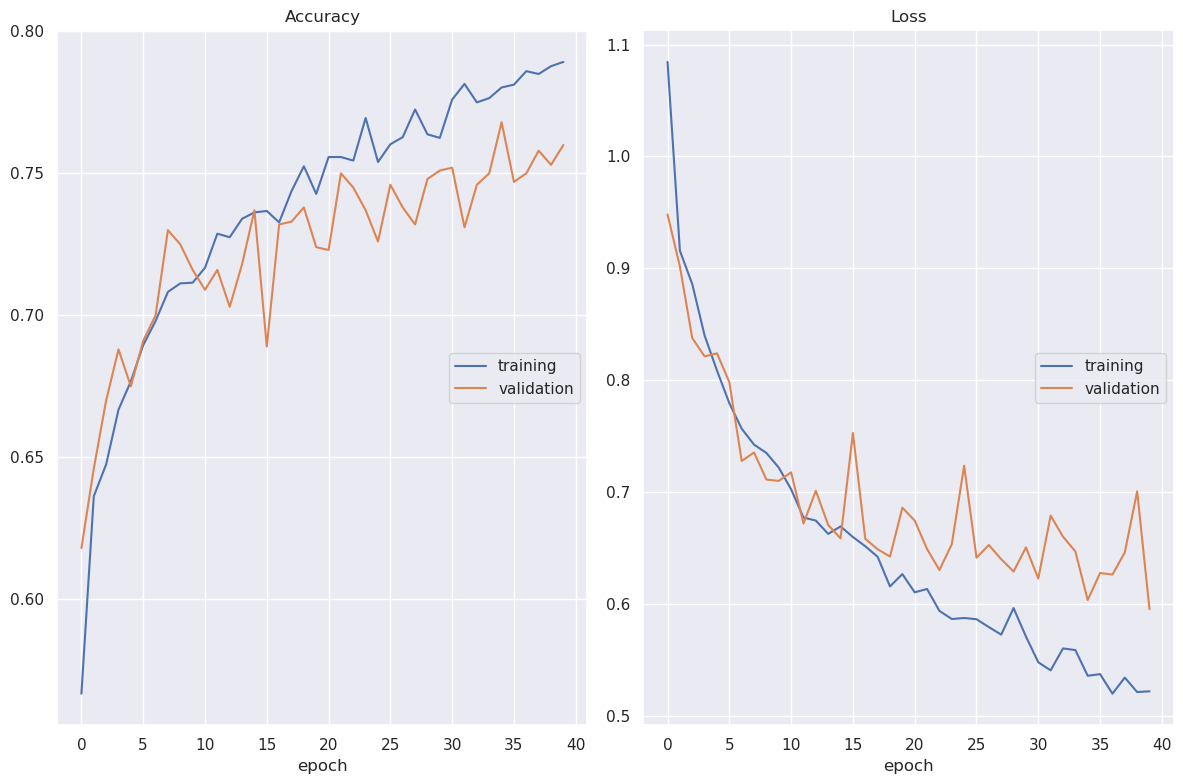

Accuracy
	training         	 (min:    0.567, max:    0.789, cur:    0.789)
	validation       	 (min:    0.618, max:    0.768, cur:    0.760)
Loss
	training         	 (min:    0.520, max:    1.084, cur:    0.522)
	validation       	 (min:    0.595, max:    0.948, cur:    0.595)
4000/4000 [==============================] - 1s 191us/sample - loss: 0.5219 - acc: 0.7893 - val_loss: 0.5954 - val_acc: 0.7600


In [116]:
#print the validation accuracy and loss after each epoch
plot_losses = PlotLossesKerasTF()

best_mlp_model.fit(X_train, y_train, 
                   validation_data=(X_test, y_test),
                   callbacks=[PlotLossesKerasTF()], verbose=1)

In [117]:
predictions = best_mlp_model.predict(X_test)

In [118]:
predictions

array([2, 3, 4, 0, 0, 3, 1, 3, 0, 1, 1, 0, 0, 4, 4, 0, 3, 3, 3, 3, 0, 0,
       1, 1, 0, 3, 3, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 2, 0, 4, 4, 3, 0,
       0, 0, 2, 0, 0, 3, 0, 4, 2, 0, 3, 4, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 2, 4, 0, 4, 0, 0, 3, 0, 2, 3, 4, 0, 2, 0, 0, 3, 0, 1, 1, 0, 3,
       0, 2, 2, 4, 3, 3, 2, 2, 0, 4, 1, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 3,
       3, 0, 2, 1, 0, 4, 4, 0, 1, 2, 3, 4, 3, 0, 0, 3, 0, 3, 1, 3, 3, 2,
       0, 3, 4, 0, 2, 0, 0, 3, 3, 0, 3, 2, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       3, 0, 0, 4, 0, 0, 0, 3, 3, 0, 0, 4, 0, 3, 0, 3, 3, 3, 3, 4, 2, 3,
       3, 0, 0, 0, 0, 0, 0, 4, 0, 4, 2, 4, 3, 2, 2, 0, 0, 0, 0, 0, 2, 3,
       0, 3, 4, 3, 0, 0, 0, 0, 0, 4, 4, 3, 3, 4, 0, 3, 3, 1, 0, 0, 4, 3,
       2, 0, 2, 4, 0, 3, 4, 1, 3, 0, 2, 0, 0, 3, 4, 1, 3, 4, 0, 0, 2, 3,
       0, 0, 1, 3, 4, 0, 0, 3, 3, 0, 0, 0, 3, 4, 0, 0, 1, 0, 0, 0, 0, 3,
       3, 0, 1, 3, 0, 1, 4, 3, 4, 0, 3, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3,
       0, 4, 0, 0, 0, 0, 3, 4, 3, 4, 0, 0, 0, 2, 0,

In [119]:
accuracy_score(y_test, predictions)

0.76

### Gerar o ficheiro de previsões (em CSV)

In [388]:
# # to generate the csv
X = data.drop('incidents', axis=1)
Y = test

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

scaler_Y = MinMaxScaler(feature_range=(0, 1)).fit(Y)
Y_scaled = pd.DataFrame(scaler_Y.transform(Y[Y.columns]), columns=Y.columns)

X_train = X_scaled
y_train = data[['incidents']]

X_test = Y_scaled


In [351]:
predictions = best_mlp_model.predict(X_test)
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

## Random Forest

Implementação de um modelo com random forest.

In [120]:
X = data.drop('incidents', axis=1)
Y = data['incidents'].to_frame()

In [121]:
all_features = X.columns
all_features = all_features.tolist()

In [122]:
numerical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind in ['i','f']]
categorical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind not in ['i','f']]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=2022, stratify=Y)

In [124]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy = 'median'),
        #KNNImputer(n_neighbors=2, weights="uniform"),
        MinMaxScaler()
    ),
     numerical_features),
    (make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value='missing'),
        OneHotEncoder(categories= 'auto', handle_unknown='ignore')
    ),
        categorical_features)
)

In [125]:
preprocessor_best = make_pipeline(
    preprocessor,
    VarianceThreshold(),
    SelectKBest(f_classif, k='all')
)

In [126]:
RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))

In [127]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


1.0

In [128]:
RF_Model.score(X_test, y_test)

0.906

In [129]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 18)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

#Maximum number of levels in tree
max_depth = [2,4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [130]:
# Create the param grid
param_grid = {'randomforestclassifier__n_estimators': n_estimators,
              'randomforestclassifier__max_features': max_features,
              'randomforestclassifier__max_depth': max_depth,
              'randomforestclassifier__min_samples_split': min_samples_split,
              'randomforestclassifier__min_samples_leaf': min_samples_leaf,
              'randomforestclassifier__bootstrap': bootstrap
             }
print(param_grid)

{'randomforestclassifier__n_estimators': [100, 152, 205, 258, 311, 364, 417, 470, 523, 576, 629, 682, 735, 788, 841, 894, 947, 1000], 'randomforestclassifier__max_features': ['auto', 'sqrt'], 'randomforestclassifier__max_depth': [2, 4, 6, 8], 'randomforestclassifier__min_samples_split': [2, 5], 'randomforestclassifier__min_samples_leaf': [1, 2], 'randomforestclassifier__bootstrap': [True, False]}


In [131]:
rf_RandomGrid = RandomizedSearchCV(estimator = RF_Model, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'precision_macro', random_state=2022)

In [132]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was

CPU times: user 3.08 s, sys: 518 ms, total: 3.59 s
Wall time: 14 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['delay_in_seconds',
                                                                   

In [133]:
rf_RandomGrid.score(X_train, y_train)

0.8484531285805671

In [134]:
rf_RandomGrid.score(X_test, y_test)

0.8231452642875727

In [135]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['delay_in_seconds',
                                                                    'luminosity',
                                                                    'avg_temperature',
                                                                    'avg_atm_pressure',
                                                                   

In [136]:
print(f'Train : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train : 0.848
Test : 0.823


### Gerar ficheiro CSV (para submissão)

In [137]:
#to csv
X_train = data.drop(['incidents'], axis=1)
y_train = data['incidents'].to_frame()
X_test = test

In [138]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['delay_in_seconds',
                                                                   

In [139]:
predictions = rf_RandomGrid.predict(X_test)
predictions

array([4, 0, 3, ..., 3, 1, 3])

In [140]:
#to csv
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

predictions

,Incidents
1,Very_High
2,None
3,High
4,Low
5,High
...,...
1202,None
1203,Very_High
1204,High
1205,Low


## XGBoost

Implementação de um modelo com XGBoost.

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=2022, stratify=Y)

In [419]:
preprocessor = make_column_transformer(
    (make_pipeline(
        KNNImputer(n_neighbors=2, weights="uniform"),
        MinMaxScaler()),
     numerical_features),
    (make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value='missing'),
        OneHotEncoder(categories= 'auto', handle_unknown='ignore')
    ),
        categorical_features)
)

preprocessor_best = make_pipeline(
    preprocessor,
    VarianceThreshold(),
    SelectKBest(f_classif, k=18)
)

In [420]:
XG_Model = make_pipeline(preprocessor_best, XGBClassifier(n_estimators = 100))

In [421]:
%%time
XG_Model.fit(X_train, y_train)

/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 47.6 s, sys: 2.66 s, total: 50.3 s
Wall time: 4.32 s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['delay_in_seconds',
                                                                    'luminosity',
                                                                    'avg_temperature',
                                                                    'avg_atm_pressure',
                                                                    'avg_humi

In [422]:
XG_Model.score(X_test, y_test)

0.9095580678314491

K-Fold Cross Validation

In [423]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = make_pipeline(
        preprocessor_best,
        XGBClassifier(random_state=2022, n_jobs=-1, **params)
    )
    model.fit(X_train, train_targets)
    train_accuracy = model.score(X_train, train_targets)
    val_accuracy = model.score(X_val, val_targets)
    return model, train_accuracy, val_accuracy

In [424]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2022)

In [425]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], np.ravel(Y.iloc[train_idxs])
    X_val, val_targets = X.iloc[val_idxs], np.ravel(Y.iloc[val_idxs])
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                            train_targets, 
                                                            X_val, 
                                                            val_targets, 
                                                            max_depth=4, 
                                                            n_estimators=20)
    models.append(model)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

Train Accuracy: 0.9066838046272494, Validation Accuracy: 0.8653648509763617
Train Accuracy: 0.9069408740359897, Validation Accuracy: 0.8756423432682425
Train Accuracy: 0.9015424164524422, Validation Accuracy: 0.8653648509763617
Train Accuracy: 0.9000257003341043, Validation Accuracy: 0.8703703703703703
Train Accuracy: 0.9079928039064508, Validation Accuracy: 0.8713991769547325


In [426]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [427]:
preds = predict_avg(models, test.reindex([1,31]))

In [428]:
def test_params_kfold(n_splits, **params):
    train_accuracys, val_accuracys, models = [], [], []
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], np.ravel(Y.iloc[train_idxs])
        X_val, val_targets = X.iloc[val_idxs], np.ravel(Y.iloc[val_idxs])
        model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                                train_targets, 
                                                                X_val, 
                                                                val_targets, 
                                                                **params)
        models.append(model)
        train_accuracys.append(train_accuracy)
        val_accuracys.append(val_accuracy)
    print('Train accuracy: {}, Validation accuracy: {}'.format(np.mean(train_accuracys), np.mean(val_accuracys)))
    return models

In [429]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.9)

Train accuracy: 1.0, Validation accuracy: 0.8934809824098394
CPU times: user 17min 16s, sys: 51.4 s, total: 18min 7s
Wall time: 1min 33s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['delay_in_seconds',
                                                                     'luminosity',
                                                                     'avg_temperature',
                                                                     'avg_atm_pressure',
                                                                  

In [430]:
#Putting it all together
XG_model_with_paramter_tuning = make_pipeline(
    preprocessor_best,
    XGBClassifier(random_state=2022, n_jobs=-1, n_estimators=500, max_depth=6, learning_rate=0.9)
)

XG_model_with_paramter_tuning.fit(X,Y)

/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['delay_in_seconds',
                                                                    'luminosity',
                                                                    'avg_temperature',
                                                                    'avg_atm_pressure',
                                                                    'avg_humi

In [411]:
predictions = rf_RandomGrid.predict(X_test)
predictions

array([0, 3, 3, 4, 4, 3, 0, 3, 3, 1, 0, 4, 0, 4, 4, 1, 0, 4, 3, 3, 3, 0,
       0, 1, 1, 4, 4, 0, 0, 2, 3, 0, 4, 3, 0, 4, 0, 3, 3, 0, 4, 4, 0, 0,
       0, 0, 0, 2, 3, 0, 3, 0, 3, 3, 0, 4, 0, 0, 0, 3, 0, 3, 0, 3, 0, 1,
       0, 3, 4, 4, 1, 0, 4, 0, 1, 0, 3, 0, 1, 0, 0, 0, 3, 3, 3, 0, 4, 0,
       0, 3, 2, 0, 0, 1, 0, 3, 0, 0, 1, 0, 0, 0, 4, 0, 2, 1, 0, 0, 3, 0,
       0, 3, 0, 0, 1, 4, 3, 2, 3, 1, 0, 4, 1, 0, 0, 0, 1, 0, 3, 0, 4, 0,
       0, 0, 0, 0, 0, 4, 3, 0, 0, 3, 4, 4, 3, 0, 0, 0, 3, 0, 4, 4, 2, 4,
       4, 2, 0, 4, 1, 4, 3, 3, 1, 3, 1, 1, 1, 4, 4, 1, 3, 0, 1, 1, 0, 1,
       0, 1, 0, 3, 3, 4, 3, 2, 3, 3, 4, 3, 4, 3, 0, 0, 4, 4, 0, 0, 0, 1,
       3, 0, 0, 3, 0, 0, 0, 4, 3, 0, 4, 4, 0, 1, 3, 4, 0, 0, 3, 0, 2, 3,
       4, 0, 3, 3, 0, 0, 3, 1, 4, 0, 4, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 2, 0, 0, 0, 4, 4, 0, 3, 0, 1, 0, 4, 1, 0, 3, 0, 3, 1, 0,
       0, 0, 3, 3, 3, 0, 0, 2, 0, 4, 4, 4, 0, 0, 3, 3, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 3, 0, 3, 0, 0, 4, 4, 1, 4, 4, 4,

Saving the model

In [415]:
incidents = {
    'model': rf_RandomGrid
}

joblib.dump(incidents, 'incidents.joblib')

['incidents.joblib']

In [417]:
test_preds2 = incidents['model'].score(X_test, y_test)
print('Test accuracy: ',test_preds2)

Test accuracy:  0.8286025890284741


Criar ficheir CSV (para submissão)

In [432]:
predictions = rf_RandomGrid.predict(test)
#to csv
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

predictions

,Incidents
1,Very_High
2,None
3,High
4,Low
5,High
...,...
1202,None
1203,High
1204,Very_High
1205,Low
